In [1]:
import DSGRN
from pychomp import *
from TransversalitySheaf import *
from ConleySheaf import *
from FlowSheaf import *
from CubicalSheaf import *

In [2]:
def dsgrn(pg, pi, method = "blowup"):
    p = pg.parameter(pi)
    if method == "original":
        dg = DSGRN.DomainGraph(p)
        md = DSGRN.MorseDecomposition(dg.digraph())
        mg = DSGRN.MorseGraph(dg, md)
        return DSGRN.DrawGraph(mg)  
    if method == "cubical":
        std = DSGRN.SubdomainGraph(p)
    elif method == "blowup":
        std = DSGRN.BlowupGraph(p)
    (dag, graded_complex)= FlowGradedComplex(std.complex(), std.diagram())
    connection_matrix = ConnectionMatrix(graded_complex)
    conleyindices = connection_matrix.count()
    fringenode = graded_complex.value(std.complex().size()-1)
    #del conleyindices[fringenode]
    CMG = InducedPoset(dag, lambda v : v in conleyindices)
    return DrawGradedComplex(connection_matrix, CMG)

In [3]:
def ComputeDatabase(netspec, params = None):
    network = DSGRN.Network(netspec)
    pg = DSGRN.ParameterGraph(network)
    if not params:
        params = range(0,pg.size())
    return DSGRN.Table( ['ParameterIndex','Original', 'Cubical', 'Blowup'], 
                   [[pi,
                     dsgrn(pg, pi, "original"), 
                     dsgrn(pg, pi, "cubical"), 
                     dsgrn(pg, pi, "blowup")] for pi in params])

In [4]:
ComputeDatabase("X : ~Y\n Y : ~X\n")

ParameterIndex,Original,Cubical,Blowup
0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 FP { 0, 0 }","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0)","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0) <!-- 1 --> 1 7 : (0, 2, 1) <!-- 1->0 --> 1->0"
1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 FP { 1, 0 }","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0)","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0) <!-- 1 --> 1 5 : (0, 2, 1) <!-- 1->0 --> 1->0"
2,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 FP { 1, 0 }","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0)","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0) <!-- 1 --> 1 7 : (0, 2, 1) <!-- 1->0 --> 1->0"
3,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 FP { 0, 1 }","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0)","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 0 : (1, 0, 0) <!-- 1 --> 1 5 : (0, 2, 1) <!-- 1->0 --> 1->0"
4,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 FP { 0, 1 } <!-- 1 --> 1 FP { 1, 0 }","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphvi

In [5]:
#Specs
netspec = "X : ~Y\n Y : ~X\n"
network = DSGRN.Network(netspec)
pg = DSGRN.ParameterGraph(network)

In [6]:
# C,flow_map = dsgrnComplex(pg,0)
# for top_cell in C(C.dimension()):
#     print(top_cell,type(flow_map(top_cell)))
#discrete_flow = {top_cell: flow_map(top_cell) for top_cell in C(C.dimension())}

In [7]:
def dsgrnComplex(pg, pi, method = "blowup"):
    p = pg.parameter(pi)
    if method == "original":
        dg = DSGRN.DomainGraph(p)
        md = DSGRN.MorseDecomposition(dg.digraph())
        mg = DSGRN.MorseGraph(dg, md)
        return DSGRN.DrawGraph(mg)  
    if method == "cubical":
        std = DSGRN.SubdomainGraph(p)
    elif method == "blowup":
        std = DSGRN.BlowupGraph(p)
    C,flow_map = std.complex(),std.diagram()
    discrete_flow = {top_cell: flow_map(top_cell) for top_cell in C(C.dimension())}
    return C,discrete_flow

In [8]:
base_complex = GeometricCubicalComplex([[0,2],[0,2]],[2,2])

In [9]:
#Construct sheaf mapping
mapping = {}
B = base_complex.complex
for pi in B(0):
    C,discrete_flow = dsgrnComplex(pg,pi)
    print(type(C),type(discrete_flow))
    mapping[pi] = FlowComplex(C,discrete_flow)

<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>
<class 'pychomp._chomp.DualComplex'> <class 'dict'>


In [10]:
for cell in B:
    if B.rightfringe(cell): continue
    print(cell, B.boundary({cell}))

0 set()
1 set()
2 set()
3 set()
4 set()
5 set()
6 set()
7 set()
8 set()
9 {0, 1}
10 {1, 2}
12 {3, 4}
13 {4, 5}
15 {6, 7}
16 {8, 7}
18 {0, 3}
19 {1, 4}
20 {2, 5}
21 {3, 6}
22 {4, 7}
23 {8, 5}
27 {9, 18, 19, 12}
28 {10, 19, 20, 13}
30 {12, 21, 22, 15}
31 {16, 13, 22, 23}


In [11]:
vertex_flow_sheaf = CubicalSheaf(base_complex, mapping)

In [12]:
flow_sheaf = SheafFromVertices(vertex_flow_sheaf)

In [13]:
graded_sheaf = GradeFlowSheaf(flow_sheaf)

In [14]:
graded_sheaf

In [15]:
graded_sheaf.mapping[0]

In [16]:
DSGRN.Table( ['ParameterIndex','Conley Complex'], 
                [[pi, DrawGradedComplex(graded_sheaf.mapping[pi].graded_complex,graded_sheaf.mapping[pi].poset)] for pi in B(0)])

In [17]:
conley_sheaf = ConleySheaf(graded_sheaf)

In [18]:
B_cells = [cell for cell in B if not B.rightfringe(cell) ]

In [19]:
DSGRN.Table( ['ParameterIndex', 'Dimension', 'Conley Complex'], 
                [[pi, B.cell_dim(pi), DrawGradedComplex(conley_sheaf.mapping[pi].graded_complex,
                                        conley_sheaf.mapping[pi].poset)] for pi in B_cells])

In [20]:
face_poset = base_complex.face_poset

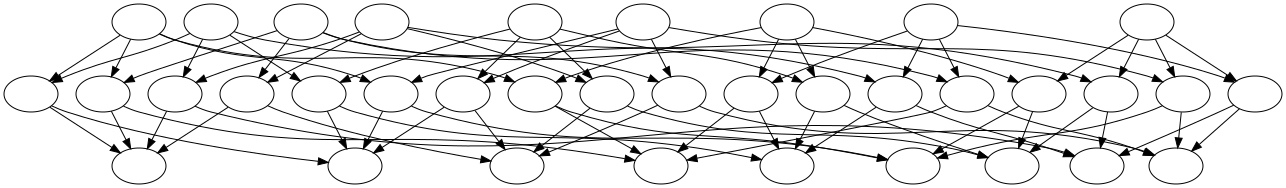

In [21]:
face_poset

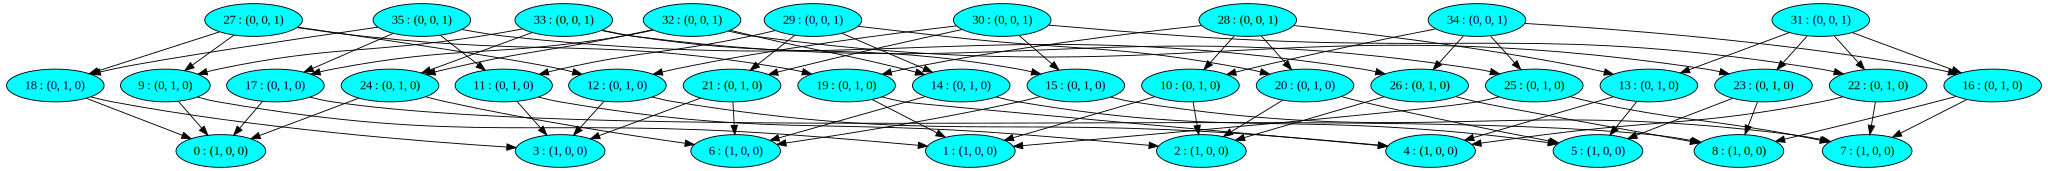

In [22]:
DrawGradedComplex(GradedComplex(B,lambda x : x), Poset(face_poset))

In [23]:
def poset_iso(gcmap,source,target):
    poset_map = gcmap.poset_map
    img = [poset_map(v) for v in source.poset.vertices()]
    img_set = set(img)
    #Check injective
    if not len(img)==len(img_set):
        return False
    #Check surjective
    if not img_set==target.poset.vertices():
        return False
    return True
def subposet_iso(poset_map, A, B):
    #A,B the subposets
    img = [poset_map(v) for v in A.vertices()]
    img_set = set(img)
    if not len(img)==len(img_set):
        return False
    if not img_set==B.vertices():
        return False
    return True

In [24]:
def InducedPoset( G, predicate ):
    result = DirectedAcyclicGraph()
    S = set([v for v in G.vertices() if predicate(v)])
    for v in S:
        result.add_vertex(v)
    for v in S:
        for u in G.children(v):
            if u in S and u != v:
                result.add_edge(v,u)
    return Poset(result)

In [25]:
a,b=3,21
gc_a = conley_sheaf.mapping[a]
rc_a = InducedPoset(gc_a.poset, lambda v : v in gc_a.graded_complex.count() )

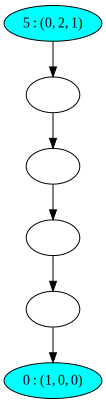

In [26]:
DrawGradedComplex(gc_a.graded_complex,gc_a.poset)

In [27]:
gc_b = conley_sheaf.mapping[b]
rc_b = InducedPoset(gc_b.poset, lambda v : v in gc_b.graded_complex.count() )

In [44]:
type(gc_b.poset)

pychomp.Poset.Poset

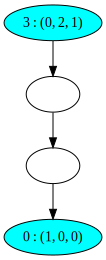

In [28]:
DrawGradedComplex(gc_b.graded_complex, gc_b.poset)

In [29]:
conley_map = conley_sheaf.mapping[(b,a)]

In [30]:
subposet_iso(conley_map.poset_map,rc_a,rc_b)

True

In [31]:
conley_map.poset_iso(gc_a,gc_b)

False

In [32]:
reducedFlag = False
localize = face_poset
for (u,v) in face_poset.edges():
    if B.rightfringe(u) or B.rightfringe(v): continue
    conley_map = conley_sheaf.mapping[(u,v)]
    gc_u = conley_sheaf.mapping[u]
    gc_v = conley_sheaf.mapping[v]
    rc_u = InducedPoset(gc_u.poset, lambda v : v in gc_u.graded_complex.count() )
    rc_v = InducedPoset(gc_v.poset, lambda v : v in gc_v.graded_complex.count() )
    if reducedFlag:
        if subposet_iso(conley_map.poset_map, rc_v, rc_u):
            print(v,u)
            localize.add_edge(v,u)
    else:
        if conley_map.poset_iso(conley_sheaf.mapping[v],conley_sheaf.mapping[u]):
            print(v,u)
            localize.add_edge(v,u)

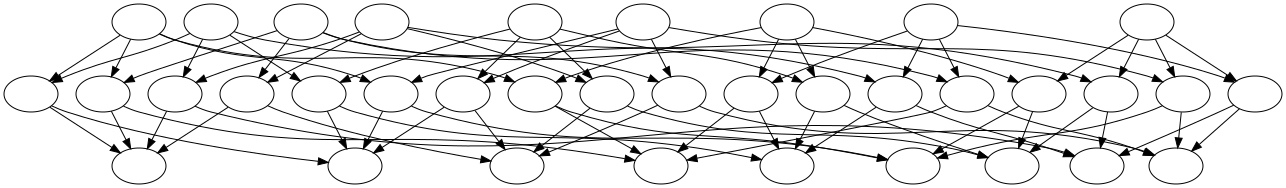

In [33]:
localize

In [34]:
# #Localize around poset isomorphism
# localize = face_poset
# for (u,v) in face_poset.edges():
#     conley_map = conley_sheaf.mapping[(u,v)]
#     if conley_map.poset_iso(conley_sheaf.mapping[v],conley_sheaf.mapping[u]):
#         localize.add_edge(v,u)

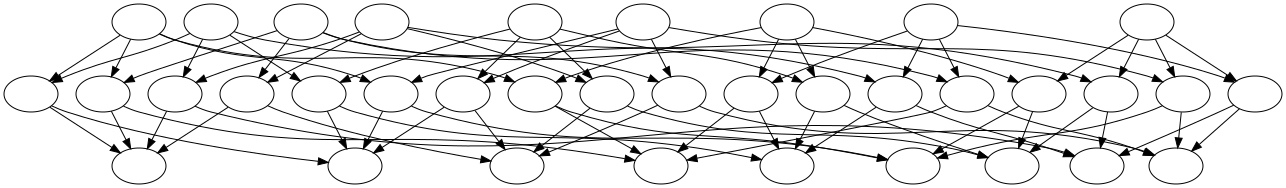

In [35]:
face_poset

In [36]:
scc,mapping = CondensationGraph(face_poset.vertices(),lambda x : face_poset.adjacencies(x))

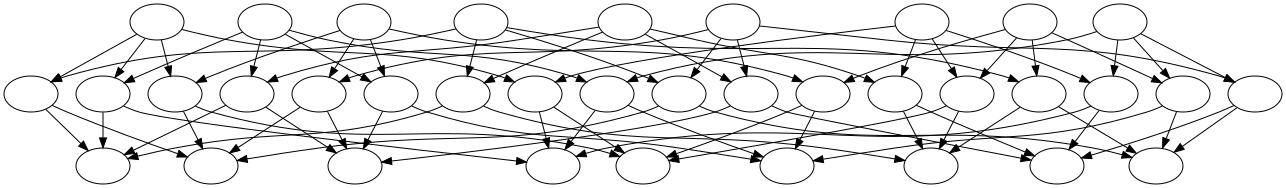

In [37]:
scc

In [38]:
graded_base = GradedComplex(base_complex.complex, lambda x : mapping[x])

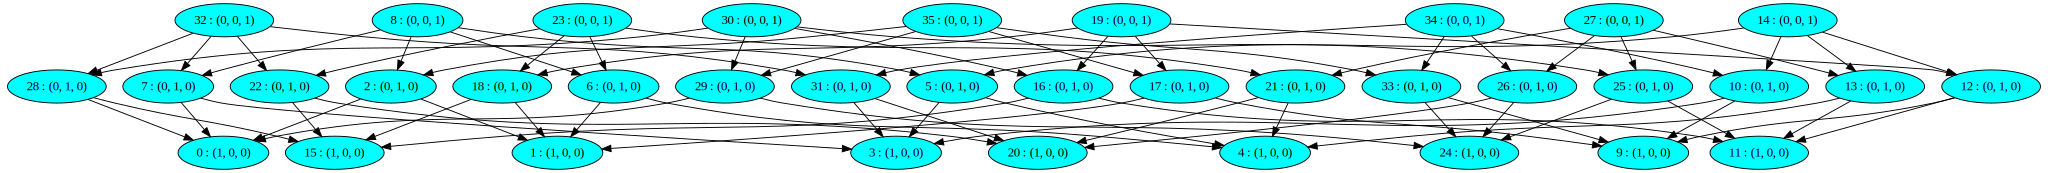

In [39]:
DrawGradedComplex(graded_base,Poset(scc))

In [40]:
reduced_base = ConnectionMatrix(graded_base)

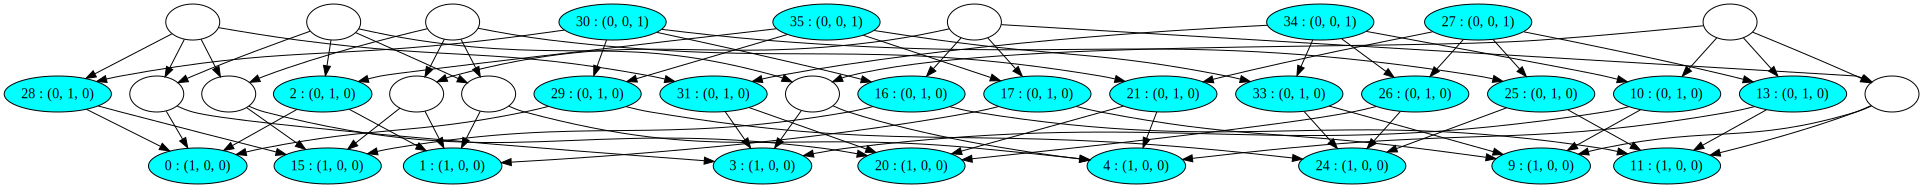

In [41]:
DrawGradedComplex(reduced_base,Poset(scc))